誰適合閱讀這篇文章：熟悉 Hash, Set, Tries (Prefix and Suffix Tree) 等資料結構和有志從事大量資料分析的電腦工程師

主要解決問題：給定一份文件，如何在網際網路的無盡文件大海中，找到相似的文件？
主要應用：偵測剽竊 (Plagiarism)，搜尋引擎欲尋找鏡像網頁，網路購物或電影推薦系統中的協同過濾

綱要：
1. 如何快速比較兩文件集合並提供量化結果:  
    a.  如何定義相似度？  
    b.  如何重新定義相似度比較問題為集合問題。 
2. <p style="color:LightGrey">如何實現快速比較高相似度文件（第二篇)</p>  
3. <p style="color:LightGrey">應用相似搜尋於巨量資料: minHash and Locality-Sensitive Hashing （第三篇）</p>
4. <p style="color:LightGrey">更多關於 Locality-Sensitive Hashing （末篇）</p>

在閱讀這篇教學後，妳將會學到：
1. 現行的文獻技術中，如何定義兩文件的相似度？
2. 如何使用 Shingle 來轉換原問題為集合比較問題？
3. 如何使用 Jaccard similarity 來比較文件的相似度？

在進入如何實作快速且有效比較大量文件之前，我們先來瞭解一下，在現行的文獻技術中，有哪些數值標準，可以用來量化兩份文件的相似程度。

給定兩個有著相同長度的字串，最簡單的方法，便是我們可以數有幾個不一樣的字母，來當作兩個字串相異的程度。  
這就是 Hamming Distance 所採用的方法，簡單的舉例：

H<span style="color:red"><b>a</b></span>rry  Potter  
H<span style="color:red"><b>e</b></span>rry  Potter  
0<span style="color:blue"><b>1</b></span>000  000000 => 若相同字母則用 0，不同字母則用 1  

由上可看得到字串一："Harry Potter" 和字串二："Herry Potter" 相異程度只有 1 （相似度則高達 10）。   
同樣的比較另外兩個字串：  

<span style="color:red"><b>Ha</b></span>rry Po<span style="color:red"><b>t</b></span>ter  
<span style="color:red"><b>Fe</b></span>rry Po<span style="color:red"><b>s</b></span>ter  
<span style="color:blue"><b>11</b></span>000 00<span style="color:blue"><b>1</b></span>000  

嗯，用肉眼看都覺得差很多。不過電腦沒有肉眼可看，也沒有人卓越大腦具有的平行處理的能力。  
所以請幫幫電腦瞭解，該怎麼用 Hamming distance 比較兩字串的相異程度吧！  

In [3]:
from functools import reduce
from operator import add
def hamming_distance(str1, str2):
    assert(len(str1) == len(str2))
    return(reduce(add, [ch1 != ch2 for ch1, ch2 in zip(str1, str2)]))

str1, str2 = 'Harry Potter', 'Ferry Poster'
print('Hamming distance for \'{}\' and \'{}\' is {}'.format(
        str1, str2, hamming_distance(str1, str2)))

Hamming distance for 'Harry Potter' and 'Ferry Poster' is 3


Hamming distance 一開始是用在電信通訊時，檢查傳輸是否正確，通常數位傳輸都是以 0/1 來表示，一般的應用是用來比較兩個二元字串，如 01000... 和 10000...。但如我所舉的例子，其應用並不只限於二元字串，只要是長度相同的字串，皆可以用 Hamming distance 來表示相異程度。但這並不代表，長度相同的字串，都要用 Hamming distance 來表示。為什麼呢？

因為字串的編輯過程要比我們所看到的還要複雜。也就是，我們雖然看到 Harry Potter 和 Herry Potter 只相差一個字母，可是如果 Herry 其實是打字員將 Harry 先誤看成 Henry，又一時手誤打成了 Herry 呢？這時候，我們就需要第二種測量字串相異程度，Edit distance。

再繼續我們粗心打字員的例子，也就是 Harry 先經歷了刪除 ar 然後又新增成為 en，變成了 Henry。最後又將 n 取代成了 r，才成為我們現在所看到的 Herry。從 Harry 到 Herry 所需的編輯步驟，則包括了兩個刪除 (deletions)，兩個新增 (insersions) 和一個取代 (replacement)。如果將編輯的歷史考慮在內，而不僅只是如 Hamming distance 就所觀察到的字串來計算相異程度，Herry 跟 Harry 的距離其實比我們所想像的還要遙遠哪！

而定義有效的編輯步驟，則因應用而異。一般最簡單的應用僅會考慮，刪除和新增，因為取代本身就包含了一個刪除和一個新增。但在生物資訊的應用上，通常會假設突變取代的可能。也就是若以 DNA 序列為例，與其將鹼基的突變，看成兩個步驟，其實當作一個步驟的可能性較高，所以又另外增加了取代的編輯步驟。此外，用 Edit distance，我們再也不需要需要長度相同這個限制了，因為刪除和新增的兩個編輯步驟，我們可以任意比較兩個長度不同的字串了。

現在，我們需要再回到 Hamming distance 上。和 Hamming distance 觀念上相近，但測量的是兩集合（set）的相似程度，一般則是使用 Jaccard Similarity。如果，今天我們比較的不是兩個字串，而是兩份文件呢？在講到比較文件前，讓我們回到學生時代，老師要檢查學生的出席時，是怎麼做的呢？  

一般當然是按照學生名冊，逐一比對出席的同學，然後看有多少同學是有出席，有多少是缺席的。這個比較相同的過程，就涉及了求交集（intersection） 的觀念。

我們可以將老師的學生名冊和在教室裡的學生當作是兩個集合，這兩個集合都不包含重複的學號或學生，換句話說兩集合中的元素都是獨一無二的，但兩集合卻可以找到一對一，或一對無的對映。一對無的情況可以試想，有學生退選這門課，但學生名冊沒有立即更新，或沒有註冊這門課的學生來旁聽。  

所以，如果我們感興趣的問題是，有多少學生出席今天的課？那麼我們就可以計算在出席學生佔註冊學生和旁聽學生的**比例**。在分母的部份，也就是計算出席學生和註冊學生的共同集合則是求聯集的觀念 (union)。我們可以根據常理推斷，總出席人數絕對不會多於兩集合的聯集，也就是比例會在 0 和 1 的封閉區間內，其值不會大於 1 或小於 0。因為使用交集和聯集的比例，所有不同大小的兩集合相似度，都可以映射到 0 和 1 的數值（可是，這樣會有個小問題，來猜猜看是什麼吧？註1），所以我們也可以放心的用這個比例來當作計量方法進行比較。 

既然，我們已經從 Hamming distance 的字串比較，升級到比較集合的觀念。但在班級的比喻中，我們對於集合中的元素，有一個假設，辨識集合中的元素不能重複，事實上也是如此，因為沒有兩個人是相同的，這樣不擁有重複元素的集合，叫做 Set。但是，在比較字串中，這樣的集合顯然是不會發生的，於是我們就需要延伸 Jaccard similarity 的計算到能擁有重複元素的集合，這樣的資料結構稱為 Bag 或是 Multiset，而兩 Bags 之間的 Jaccard similarity 則又稱為 **Jaccard Bag Similarity**。在定義 Jaccard Bag Similarity 時，求交集可以用求每個元素出現在兩集合的最小頻率，而聯集的部份則有兩個做法，一是用每個元素在兩集合出現頻率的總和，但這樣的問題是， Jaccard Bag similarity 的最大值，就不再是 1 而是 1/2。為了能繼續維持 Jaccard similarity 的特性，用最大頻率來代表聯集，較常使用於不同元素數量的 Bag 比較。

拿書上的練習來作例子[1, Exercise 3.1.2]：假設有三個 bags 分別為：

A = {1, 1, 1, 2}  
B = {1, 1, 2, 2, 3}  


則若將 A, B 當作不可有重複元素的 Set 來看，集合會變成：  
A = {1, 2}  
B = {1, 2, 3}  

則 Jaccard similarity 為 
$\frac{A \cap B}{A \cup B} = \frac{\{1, 2\}}{\{1, 2, 3\}}= \frac{2}{3}$  
但若是將 A, B 當作可有重複元素的 Bag/MultiSet 來看，則 Jaccard Bag Similairity 則為：  
$\frac{A \cap B}{A \cup B} =\
 \frac{min(A, B)}{max(A, B)} =\ \frac{2+1+0}{3+2+1}=\frac{1}{2}$
 
看起來就沒有這麼相似啦！這就是 Jaccard Similarity 的定義。而簡單的 python code 和兩個例子代表的 Venn Graph 則是如下：

In [4]:
from functools import reduce
from operator import or_
from operator import and_
from operator import add
from itertools import zip_longest
from collections import namedtuple

def jaccard_similarity(str1, str2, allow_repeat=False):
    if not allow_repeat:
        if type(str1) == set and type(str2) == set:
            uniqs = [str1, str2]
        uniqs = list(map(set, [str1, str2]))
        return(len(reduce(and_, uniqs))/len(reduce(or_, uniqs)))
    else:
        freqs = {k: [0, 0] 
                for k in reduce(or_, list(map(set, [str1, str2])))}
        for ch1, ch2 in zip_longest(str1, str2):
            if ch1 is not None:
                freqs[ch1][0] += 1
            if ch2 is not None:
                freqs[ch2][1] += 1
        return(reduce(add, map(min, freqs.values()))/ reduce(add, map(max, freqs.values())))
        
str1, str2 = '1112', '11223'
print('Jaccard Similarity for sets \'{}\' and \'{}\' is {:.2f}:'.format(
        str1, str2, jaccard_similarity(str1, str2)))
print('Jaccard Similarity for bags \'{}\' and \'{}\' is {:.2f}:'.format(
        str1, str2, jaccard_similarity(str1, str2, True)))

Jaccard Similarity for sets '1112' and '11223' is 0.67:
Jaccard Similarity for bags '1112' and '11223' is 0.50:


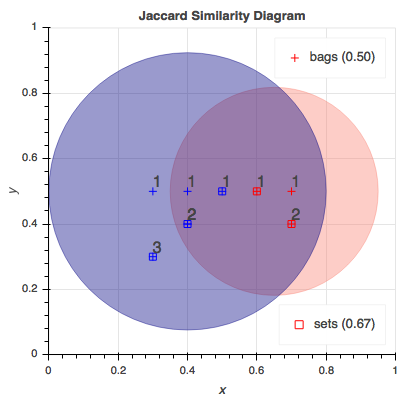

In [5]:
from IPython.display import Image
Image(filename='plot.png')

再進入 Shingle 的觀念前，讓我們稍微整理一下之前所說的；

**Hamming distance** 是量測兩個相同長度的字串相異性，可以把兩個字串當成兩個字母的集合，而字母則是集合中的元素。
**Jaccard similarity** 是量測兩個集合的相似性，比較兩集合中相同的元素，並將相似程度量化成在 0 到 1 的比例。
**Edit distance** 是在將編輯歷史考慮在內的情況下量測兩任意字串相異性，簡單的說，就是定義 A 字串需要多少編輯步驟才能變成 B 字串。

先有了集合的概念後，和如何比較集合間的相似，接下來就是如何定義集合內元素。定義集合內的元素之所以重要，是因為元素的定義會影響比較的方法，規模，最終會影響集合比對的結果。在文字探勘的領域中，Shingling 就是一個常用的技術 [註 2]。Shingle 原本意思是鵝卵石，通常也可以當作建築的材料，在這裡可以看作是建立集合的基石。Shingle 可以是一個字彙，也可以是一個字母，可以是 K 個重疊且相連（overlapping and consecutive）的字母，或 K 個重疊且相連的字彙，端看應用為何？在網頁搜尋的應用中，多半是在字元的層級上來做分析，所以在錯別字或是同義字替換的容忍度上，沒有這麼高，也就無法作為語意理解的學習模型，但在低層級的比較上，如文件分析（Textual Analysis）卻已足夠。通常以單一 Shingle 作為集合中的元素，會造成集合間的低變異，因為較少的可用元素組合。試想，以英文字母作為 Shingle 來比較文件，若不考慮標點符號，總共只有 26 個選擇，以及若以 K 個字母作為 K-Shingle，則有 $26^K$ 個選擇，顯然地，後者可以組合的集合數目要大的多了！

我們現在稍微改變一下書中現成的例子[Example 3.4]，來說明定義 Shingle 對於比較集合相似度的影響：   
句子一： "the plane was ready for touch down"    
句子二： "the quarterback was ready for scoring a touchdown"   
皆不考慮大小寫，計算 Jaccard Similarity 的結果如下：

| Definition of Shingles        | Jaccard Similarity| 
| :------------- |:-------------:| 
| 以單一字母為 1-Shingle，不考慮空白|0.67|
| 以 9 個字母為 9-Shingles，考慮空白|0.12| 
| 以 9 個字母為 9-Shingles，不考慮空白 |0.08|
| 以 3 個字彙為 3-Shingle words，不考慮 stop words |0.10|
| 以 3 個字彙為 3-Shingle words，考慮 stop words [註 3]|0.20|

In [6]:
def shingle(k, doc, remove_whitespaces = False):
    """ calculate shingle given k by characters

    >>> sorted(shingle(2, ["abcdabd"]))
    ['ab', 'bc', 'bd', 'cd', 'da']
    >>> shingle(9, ["The plane was ready for touch down"]) \
    ... & shingle(9, ["The quarterback scored a touchdown"])
    set()
    >>> shingle(9, ["The plane was ready for touch down"], True)\
    ... & shingle(9, ["The quarterback scored a touchdown"], True)
    {'touchdown'}
    """

    shingles = set()
    for line in doc:
        if remove_whitespaces:
            line = line.replace(" ","")
        for i in range(0, len(line) - k + 1):
            shingles.add(line[i:i+k])

    return(shingles)

def word_shingle(k, doc, use_stopword=True):
    """ calculate shingle given k by words

    >>> set(["A spokesperson for", "for the Sudzo", "the Sudzo Corporation", 
    ... "that studies have", "have shown it", "it is good", "is good for", 
    ... "for people to", "to buy Sudzo"]) == word_shingle(3,
    ... ["A spokesperson for the Sudzo Corporation revealed today "
    ... "that studies have shown it is good for people to buy Sudzo products."])
    True
    >>> set(["A spokesperson for", "spokesperson for the", "for the Sudzo", 
    ... "the Sudzo Corporation"]) == word_shingle(3,
    ... ["A spokesperson for the Sudzo Corporation"], False)
    True
    """

    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize

    shingles = set()
    for line in doc:
        tokens = word_tokenize(line)
        for i in range(0, len(tokens) - k + 1):
            if use_stopword == True and tokens[i].lower() \
              in stopwords.words('english'):
                shingles.add(' '.join(tokens[i:i+k]))
            if not use_stopword:
                shingles.add(' '.join(tokens[i:i+k]))
            i = i + 1
    return(shingles)

def print_out(k, str1, str2, call_back, **kwargs):
    print("========")
    results = [call_back(k, [s], **kwargs) for s in [str1, str2]]
    print("the {}-shingle set from str1 is \n({})".format(k, ','.join(results[0])))
    print("the {}-shingle set from str2 is \n({})".format(k, ','.join(results[1])))
    print("the Jaccard similarity between two is {:.2f}".format(
        jaccard_similarity(*results)))

str1, str2 = "the plane was ready for touch down", \
  "the quarterback was ready for scoring a touchdown"
print_out(1, str1, str2, shingle, remove_whitespaces=True)
# comment 9-shingle output for clean output
# print_out(9, str1, str2, shingle)
# print_out(9, str1, str2, shingle, remove_whitespaces=True)
print_out(3, str1, str2, word_shingle, use_stopword=False)
print_out(3, str1, str2, word_shingle)

the 1-shingle set from str1 is 
(u,e,r,y,l,h,p,n,s,d,o,f,w,a,c,t)
the 1-shingle set from str2 is 
(g,i,u,e,r,q,y,h,b,s,d,o,n,f,w,a,c,k,t)
the Jaccard similarity between two is 0.67
the 3-shingle set from str1 is 
(the plane was,was ready for,for touch down,plane was ready,ready for touch)
the 3-shingle set from str2 is 
(ready for scoring,scoring a touchdown,quarterback was ready,was ready for,the quarterback was,for scoring a)
the Jaccard similarity between two is 0.10
the 3-shingle set from str1 is 
(the plane was,was ready for,for touch down)
the 3-shingle set from str2 is 
(was ready for,the quarterback was,for scoring a)
the Jaccard similarity between two is 0.20


不過，定義了 Shingle 只是向較為完備的語言分析跨進了一小步，面對廣袤的文件大海，兩兩比對文件的相似度，仍會造成如天文數字般可怕的計算數目，所以在實務巨量資料的應用上，我們仍然需要非常快速的方法來實現，這些技巧將會在下面幾篇提到。

最後，希望本文能引起許多女孩對於演算法的興趣，同時對平日相當散漫的我，能有效釐清一些困惑。若本文有任何不盡完善的地方，敬請批評指教囉！

註 1: 兩集合可以擁有相當高的 Jaccard Similarity，但不一定具有統計上的相似意義（statistical significance）。試想，若因為取樣誤差，兩集合都只包括一個元素，那麼 Jaccard Similiaryt 不是 1 就是 0，這樣計算出來的結果，誤導性就相當高了！  
註 2: Shingle 和文字探勘領域中經常使用的 n-gram，在 [wiki](https://en.wikipedia.org/wiki/N-gram) 上的區別有點讓人感到困惑。Shingle 此詞最早是出現在 Border et al. 1997 年的文章，並沒有特別指出 Shingle 必須是字詞為單位，相反的只是定義 Shinge 為相連的子字串。（a contiguous subsequence）。事實上，我懷疑只是兩個可互相交換而不改變意義的專有名詞，只是 n-gram 的應用領域較廣，較為人知罷了！  
註 3: stop words 指的是語言模型中經常使用，但在文件比較中不具有識別性的效果。如定冠詞 the 和不定冠詞 a。

Reference:
[1] Ch 3 Finding Similar Measure in Mining Massive Datasets by Jure Leskovec, Anand Rajaraman, Jeffrey D. Ullman
Coursera Mining Massive Datasets course (Ch 3-1, 3-2 and some sections from 3-5)